In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from label_names import *

path = os.getcwd()
if path.split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
from src.engine import Engine
from src.utils.util import *
from src.core.datasets import *
from src.utils.util import *
from src.core.criterions import *
%matplotlib inline

In [3]:
config_path = 'configs/mln_resnet18_voc.yml'
save_dir = '/home/yo0n/바탕화면/RIL/ucam/notebook_test'
logger = load_log(save_dir)
checkpoint_path = '/home/yo0n/바탕화면/RIL/ucam/ckpt_voc/voc_ood.pth'

In [4]:
engine = Engine(config_path, logger, save_dir,device='cuda')
engine.model_config['checkpoint_path'] = checkpoint_path
engine.define()


[2021-08-20 15:08:14,450 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] GPU is available.


Build a dataloader
Build a model


[2021-08-20 15:08:17,600 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] SGD opimizer is built.
[2021-08-20 15:08:17,601 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] CUSTOM scheduler is built.
[2021-08-20 15:08:17,602 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Criterion is built.
[2021-08-20 15:08:17,602 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loss meter is built.
[2021-08-20 15:08:17,602 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Checkpointer is built.
[2021-08-20 15:08:17,603 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Loading checkpoint from /home/yo0n/바탕화면/RIL/ucam/ckpt_voc/voc_ood.pth
[2021-08-20 15:08:17,705 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Localizer is built.
[2021-08-20 15:08:17,706 - /home/yo0n/바탕화면/RIL/ucam/notebook_test] Evaluators are built.


### OOD Calculation

In [5]:
indist  = VOC2012('./data/VOCdevkit', metadata_split='val',crop_size=224,train_full=None, scale=True, flip=True, ood=True,  outdist=False)
outdist = VOC2012('./data/VOCdevkit', metadata_split='val',crop_size=224,train_full=None, scale=True, flip=True, ood=True,  outdist=True)

In [6]:
len(indist),len(outdist)

(644, 509)

In [1]:
def get_uncertainty_distribution(dataset):
    epis_list = list()
    alea_list = list()
    for idx,(voc_sample_img, voc_sample_label, voc_sample_mask) in enumerate(dataset):
        inpt = torch.tensor(voc_sample_img).unsqueeze(0)/255.
        with torch.no_grad():
            output_dict = engine.model(inpt.cuda().float())
        preds = mln_gather(output_dict)['mu_sel']
        pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
        largest_pi_ind = torch.argmax(pi)
        unct_out = mln_uncertainties(pi, mu, sigma)
        alea , epis = float(unct_out['alea']), float(unct_out['epis'])
        alea_list.append(alea)
        epis_list.append(epis)
        
        
    return {'alea':alea_list,'epis':epis_list}

In [2]:
indist_out  = get_uncertainty_distribution(indist)
outdist_out = get_uncertainty_distribution(outdist)

NameError: name 'indist' is not defined

(array([0.08240036, 0.16480071, 0.90640393, 1.56560678, 3.29601428,
        4.86162107, 6.09762642, 5.76802499, 6.34482749, 4.77922071,
        4.28481857, 1.89520821, 1.23600536, 0.49440214, 0.16480071]),
 array([0.51536947, 0.53921205, 0.56305462, 0.58689719, 0.61073977,
        0.63458234, 0.65842491, 0.68226749, 0.70611006, 0.72995263,
        0.75379521, 0.77763778, 0.80148035, 0.82532293, 0.8491655 ,
        0.87300807]),
 <BarContainer object of 15 artists>)

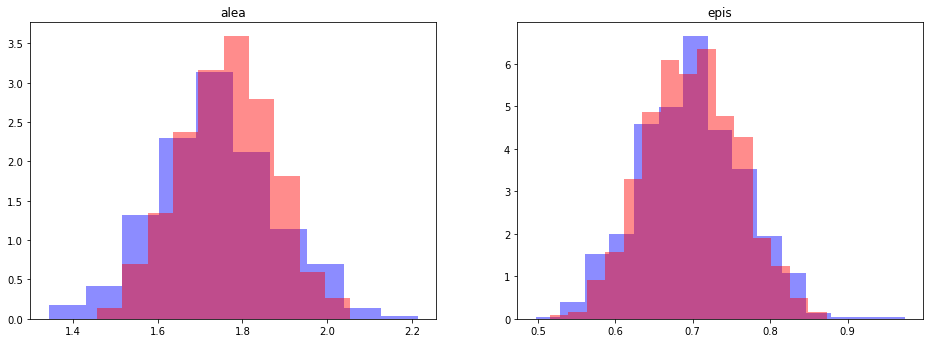

In [9]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.title("alea")
plt.hist(indist_out['alea'], color='blue', alpha=0.45, density=True, label='ID')
plt.hist(outdist_out['alea'], color='red', alpha=0.45, density=True, label='OoD')
plt.subplot(2,2,2)
plt.title("epis")
plt.hist(indist_out['epis'], bins=15, color='blue', alpha=0.45, density=True, label='ID')
plt.hist(outdist_out['epis'], bins=15, color='red', alpha=0.45, density=True, label='OoD')

### CAM / U-CAM

unseen class - (ood)

tensor([[0.0013, 0.0023, 0.0036, 0.0012, 0.0008, 0.0047, 0.0018, 0.0059, 0.0327,
         0.0737, 0.0299, 0.0108, 0.0122, 0.0133, 0.0079, 0.7133, 0.0159, 0.0095,
         0.0020, 0.0018, 0.0033]])
tensor([15,  9,  8])


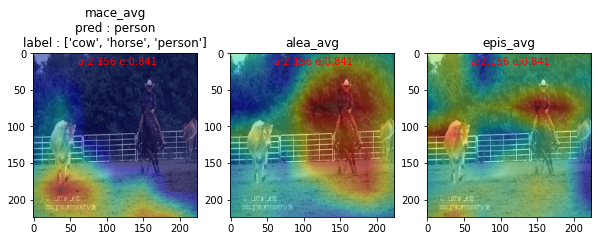

In [10]:
loss_types = ['mace_avg','alea_avg','epis_avg']

(voc_sample_img, voc_sample_label, voc_sample_mask) = indist[70]
orgImg = ((voc_sample_img.transpose(1,2,0) + np.array((104.008, 116.669, 122.675)))/255.)[:,:,::-1]
inpt = torch.tensor(voc_sample_img).unsqueeze(0)/255.

with torch.no_grad():
    output_dict = engine.model(inpt.cuda().float())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel'].cpu()
ind_sel = torch.topk(mu_sel,3)[-1][0]
print(mu_sel)
print(ind_sel)

gt_sel = 0

plt.figure(figsize=(10,30))
for i,loss_type in enumerate(loss_types):
        
    engine.localizer.register_hooks()
    engine.localizer.model_ext.loss_type= loss_type
    
    pred_label = torch.tensor([ind_sel[gt_sel]]).long()
    
    
    cams = engine.localizer.localize(inpt.to('cuda').float(), pred_label.to('cuda'))
    cams = cams.cpu().detach().squeeze().numpy()
        
    epis = unct_out['epis'][0]
    alea = unct_out['alea'][0]    
        
    plt.subplot(3,3,i+1)
    if loss_type=='mace_avg':
        pass
        classes = list(np.where(voc_sample_label[1:]==1)[0]+1)
        class_names = str([voc_label_names[c] for c in classes])
        pred_name = voc_label_names[int(ind_sel[gt_sel])].split(',')[0]
        plt.title(loss_type + '\npred : ' + pred_name + '\nlabel : ' + class_names)
    else:
        plt.title(loss_type)
    plt.imshow(orgImg)
    plt.imshow(cams, alpha=0.4, cmap='jet')
    plt.text(60, 15, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10,color='red')

In [ ]:
from src.core.criterions import *

%matplotlib inline

loss_types = ['mace_avg','epis_avg','alea_avg']

with torch.no_grad():
    output_dict = engine.model(inpt.cuda().float())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel'].cpu()
ind_sel = torch.topk(mu_sel,3)[-1][0]

plt.figure(figsize=(10,30))

largest_pi_ind = torch.argmax(pi)
mixture_k = engine.model.mol.fc_pi.weight.size(0)

plt.figure(figsize=(10,50))
for k in range(mixture_k):
    engine.localizer.register_hooks()
    engine.localizer.model_ext.loss_type= 'mace_avg'
    mixture_pred_name = label_name[torch.argmax(mu[0,k])].split(',')[0]
    
    cat_label = torch.tensor([torch.argmax(mu[0,k])]).long()
    
    cams = engine.localizer.localize(inpt.to('cuda').float(), cat_label.to('cuda'), mixture=k)
    cams = cams.cpu().detach().squeeze().numpy()
    
    plt.subplot(mixture_k,mixture_k,k+1)
    if(largest_pi_ind==k):
        plt.title(mixture_pred_name,color='red')
    else:
        plt.title(mixture_pred_name,color='blue')
    plt.imshow(cat_and_dog)
    plt.imshow(cams, alpha=0.5, cmap='jet')

    engine.localizer.remove_hooks()

one class seen - the other unseen

In [11]:
inoutdist  = VOC2012('./data/VOCdevkit', metadata_split='train',crop_size=224,train_full=None, scale=True, flip=True, ood=True,  together=True)
len(inoutdist)

212

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[2.2249e-04, 2.4314e-04, 9.1166e-03, 2.9413e-04, 2.3201e-04, 2.5479e-03,
         1.8815e-04, 3.5147e-02, 7.6979e-04, 1.3354e-01, 5.3741e-03, 5.6367e-02,
         3.6648e-03, 5.0584e-03, 3.0207e-01, 9.9653e-01, 1.2263e-02, 2.6067e-04,
         1.8205e-04, 8.4288e-05, 9.7161e-03]])
tensor([15, 14,  9])


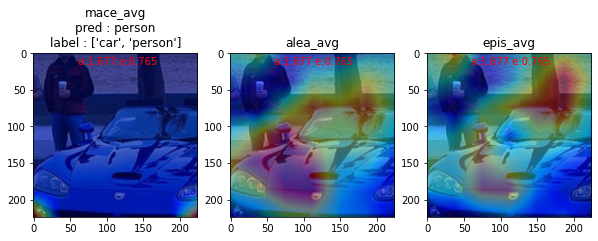

In [12]:
loss_types = ['mace_avg','alea_avg','epis_avg']

(voc_sample_img, voc_sample_label, voc_sample_mask) = inoutdist[60]
orgImg = ((voc_sample_img.transpose(1,2,0) + np.array((104.008, 116.669, 122.675)))/255.)[:,:,::-1]
inpt = torch.tensor(voc_sample_img).unsqueeze(0)/255.

with torch.no_grad():
    output_dict = engine.model(inpt.cuda().float())
pi, mu, sigma = output_dict['pi'],output_dict['mu'],output_dict['sigma']
unct_out = mln_uncertainties(pi, mu, sigma)
sel_out = mln_gather(output_dict)
mu_sel = sel_out['mu_sel'].cpu()
ind_sel = torch.topk(mu_sel,3)[-1][0]
print(mu_sel)
print(ind_sel)

gt_sel = 0

plt.figure(figsize=(10,30))
for i,loss_type in enumerate(loss_types):
        
    engine.localizer.register_hooks()
    engine.localizer.model_ext.loss_type= loss_type
    
    pred_label = torch.tensor([ind_sel[gt_sel]]).long()
    
    
    cams = engine.localizer.localize(inpt.to('cuda').float(), pred_label.to('cuda'))
    cams = cams.cpu().detach().squeeze().numpy()
        
    epis = unct_out['epis'][0]
    alea = unct_out['alea'][0]    
        
    plt.subplot(3,3,i+1)
    if loss_type=='mace_avg':
        pass
        classes = list(np.where(voc_sample_label[1:]==1)[0]+1)
        class_names = str([voc_label_names[c] for c in classes])
        pred_name = voc_label_names[int(ind_sel[gt_sel])].split(',')[0]
        plt.title(loss_type + '\npred : ' + pred_name + '\nlabel : ' + class_names)
    else:
        plt.title(loss_type)
    plt.imshow(orgImg)
    plt.imshow(cams, alpha=0.4, cmap='jet')
    plt.text(60, 15, "a:{:.3f} e:{:.3f}".format(alea,epis), fontsize=10,color='red')